<a href="https://colab.research.google.com/github/Mervvick/Mervvick-AI_CCN_Cars/blob/main/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0__%D0%91%D0%B0%D0%B7%D0%BE%D0%B2%D1%8B%D0%B9_%D0%B1%D0%BB%D0%BE%D0%BA___%D0%A1%D0%B2%D0%B5%D1%80%D1%82%D0%BE%D1%87%D0%BD%D1%8B%D0%B5_%D0%BD%D0%B5%D0%B9%D1%80%D0%BE%D0%BD%D0%BD%D1%8B%D0%B5_%D1%81%D0%B5%D1%82%D0%B8___%D0%94%D0%97_Ultra_Pro___%D0%A3%D0%98%D0%98_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Используя базу данных автомобилей, создайте сеть с точностью распознавания не ниже 93% на проверочной выборке.

Для решения задачи вы можете использовать любой подход:
- модель без аугментации данных
- аугментация данных с помощью ImageDataGenerator
- аугментация данных с помощью самописного генератора изображений
- использовать готовую архитектуру из набора `tf.keras.applications` (Обратите внимание: на занятии мы не рассматривали данный модуль фреймворка Керас. Ваша задача: попробовать самостоятельно разобраться в приципах его работы. В разборе домашнего задания вы получите ссылку на ноутбук Базы Знаний УИИ, где подробно раскрывается вопрос использования готовых архитектур)

In [ ]:
from PIL import Image, ImageEnhance
import matplotlib.pyplot as plt
import random
import numpy as np
import os
import time
import seaborn as sns
import gc
import gdown
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers.legacy import Adam
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils.vis_utils import plot_model

In [ ]:
TRAIN_PATH          = '/content/cars'
VAL_SPLIT           = 0.2

IMAGE_SIZE          = (224, 224)

ROTATION_RANGE      = 6
ZOOM_RANGE          = 0.1
BRIGHTNESS_RANGE    = (0.8, 1.3)
HORIZONTAL_FLIP     = True

BATCH_SIZE          = 32
OPTIMIZER           = Adam(0.0001)

In [ ]:
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l5/middle_fmr.zip', None, quiet=True)
!unzip -q "middle_fmr.zip" -d {TRAIN_PATH}

replace /content/cars/Ferrari/car_Ferrari__0.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [ ]:
CLASS_LIST  = sorted(os.listdir(TRAIN_PATH))
CLASS_COUNT = len(CLASS_LIST)

In [ ]:
print(f'Количество классов: {CLASS_COUNT}, метки классов: {CLASS_LIST}')

Количество классов: 3, метки классов: ['Ferrari', 'Mercedes', 'Renault']


# ImageDataGenerator

In [ ]:
'''
train_datagen = ImageDataGenerator(
                    rescale=1. / 255.,
                    rotation_range=ROTATION_RANGE,
                    zoom_range=ZOOM_RANGE,
                    brightness_range=BRIGHTNESS_RANGE,
                    horizontal_flip=HORIZONTAL_FLIP,
                    validation_split=VAL_SPLIT
                )

In [ ]:
'''
train_ds = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    subset='training'
)

val_ds = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    subset='validation'
)

In [ ]:
'''
plt.imshow(train_ds[0][0][5])
plt.show()
print(CLASS_LIST[np.argmax(train_ds[0][1][5])])

In [ ]:
'''
print(f'Формы данных тренировочной выборки: {train_ds[0][0].shape}, {train_ds[0][1].shape}, батчей: {len(train_ds)}')
print(f'Формы данных   проверочной выборки: {val_ds[0][0].shape}, {val_ds[0][1].shape}, батчей: {len(val_ds)}')
print()

print(f'Метки классов тренировочной выборки: {train_ds.class_indices}')
print(f'Метки классов   проверочной выборки: {val_ds.class_indices}')

Формы данных тренировочной выборки: (32, 224, 224, 3), (32, 3), батчей: 86
Формы данных   проверочной выборки: (32, 224, 224, 3), (32, 3), батчей: 22

Метки классов тренировочной выборки: {'Ferrari': 0, 'Mercedes': 1, 'Renault': 2}
Метки классов   проверочной выборки: {'Ferrari': 0, 'Mercedes': 1, 'Renault': 2}


# Image_dataset

In [ ]:

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  TRAIN_PATH,
  validation_split = VAL_SPLIT,
  subset = "training",
  seed = 123,
  image_size = IMAGE_SIZE,
  batch_size = BATCH_SIZE)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  TRAIN_PATH,
  validation_split = VAL_SPLIT,
  subset = "validation",
  seed = 123,
  image_size = IMAGE_SIZE,
  batch_size = BATCH_SIZE)

Found 3427 files belonging to 3 classes.
Using 2742 files for training.
Found 3427 files belonging to 3 classes.
Using 685 files for validation.


In [ ]:

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Функция графика


In [ ]:
def plot_graph(train_acc, val_acc, train_loss, val_loss):

    sns.set(style='darkgrid', palette='dark')
    plt.figure(figsize=(16, 10))
    plt.subplot(2, 2, 1)
    plt.title('Точность', fontweight='bold')
    plt.plot(train_acc, label='Точность на обучащей выборке')
    plt.plot(val_acc, label='Точность на проверочной выборке')
    plt.xlabel('Эпоха обучения')
    plt.ylabel('Доля верных ответов')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.title('Ошибка', fontweight='bold')
    plt.plot(train_loss, label='Ошибка на обучающей выборке')
    plt.plot(val_loss, label='Ошибка на проверочной выборке')
    plt.xlabel('Эпоха обучения')
    plt.ylabel('Ошибка')
    plt.legend()

    plt.show()

# Сеть

In [ ]:
preprocess_input = tf.keras.applications.resnet50.preprocess_input
gc.collect()
image_shape = IMAGE_SIZE + (3,)
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(len(CLASS_LIST), activation = 'softmax')

In [ ]:
base_model = tf.keras.applications.resnet50.ResNet50(input_shape=image_shape,
                                                    include_top=False,
                                                    weights='imagenet')

In [ ]:

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomZoom((-0.05,0.05)),
    tf.keras.layers.experimental.preprocessing.RandomContrast(0.15)])

In [ ]:
inputs = tf.keras.Input(shape=(image_shape))
x = data_augmentation(inputs)
x = preprocess_input(x)

#x = preprocess_input(inputs)

x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
OPTIMIZER = Adam(0.0001)

In [ ]:
# Компилируем модель
model.compile(optimizer=OPTIMIZER,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

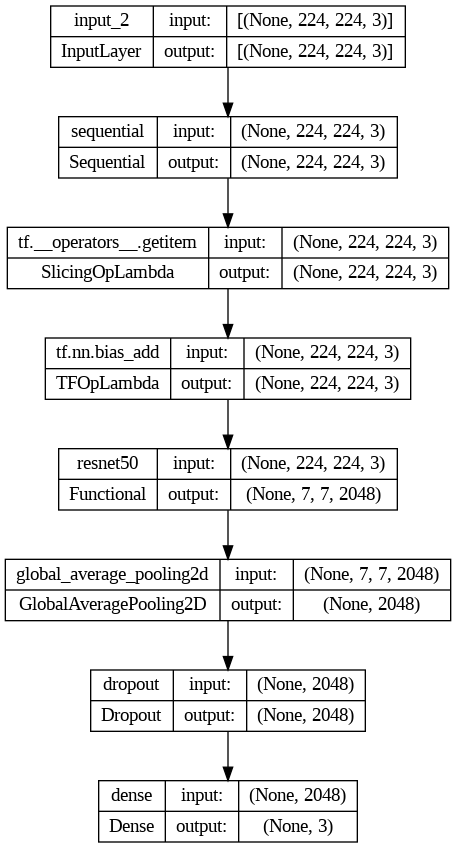

In [ ]:
plot_model(model, show_shapes = True)

# Обучение

In [ ]:
EPOCHS = 10

Epoch 1/10
86/86 [==============================] - 51s 423ms/step - loss: 0.5867 - accuracy: 0.7673 - val_loss: 0.5028 - val_accuracy: 0.7869
Epoch 2/10
86/86 [==============================] - 31s 362ms/step - loss: 0.2721 - accuracy: 0.9008 - val_loss: 0.3254 - val_accuracy: 0.8701
Epoch 3/10
86/86 [==============================] - 31s 364ms/step - loss: 0.2054 - accuracy: 0.9252 - val_loss: 0.2591 - val_accuracy: 0.9226
Epoch 4/10
86/86 [==============================] - 31s 366ms/step - loss: 0.1075 - accuracy: 0.9581 - val_loss: 0.6764 - val_accuracy: 0.8832
Epoch 5/10
86/86 [==============================] - 32s 368ms/step - loss: 0.0952 - accuracy: 0.9650 - val_loss: 0.1914 - val_accuracy: 0.9358
Epoch 6/10
86/86 [==============================] - 31s 363ms/step - loss: 0.1247 - accuracy: 0.9602 - val_loss: 0.1614 - val_accuracy: 0.9445
Epoch 7/10
86/86 [==============================] - 31s 360ms/step - loss: 0.0828 - accuracy: 0.9737 - val_loss: 0.3875 - val_accuracy: 0.9051

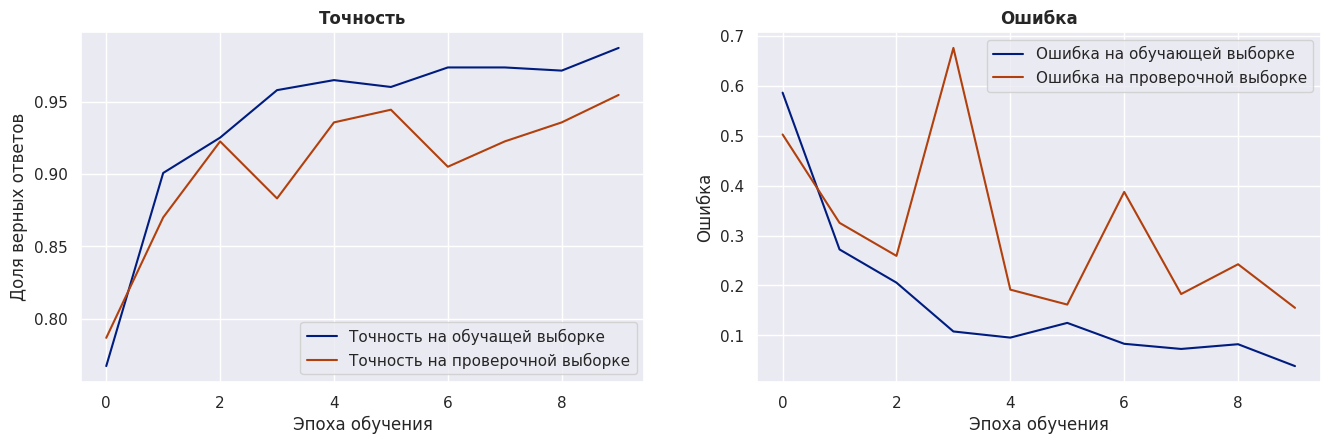

Время обучения: 391 секунд (6.52 минут)


In [ ]:
CurrentTime = time.time()

hResNet50 = model.fit(train_ds,
                      epochs=EPOCHS,
                      validation_data=val_ds)

plot_graph(hResNet50.history['accuracy'],
           hResNet50.history['val_accuracy'],
           hResNet50.history['loss'],
           hResNet50.history['val_loss'])

print('Время обучения: {:.0f} секунд ({:.2f} минут)'.format(time.time() - CurrentTime, (time.time() - CurrentTime)/60))